In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette()
%config InlineBackend.figure_format='retina'

In [3]:
y_train, y_valid, y_test = pickle.load(open('../datasets/bm/labels.pkl', 'rb'))
ytvs = y_train, y_valid, y_test
p2i_train, p2i_valid, p2i_test = pickle.load(open('../datasets/bm/img2idx.pkl', 'rb'))
i2p_train = {v:k for k, v in p2i_train.items()}
i2p_valid = {v:k for k, v in p2i_valid.items()}
i2p_test = {v:k for k, v in p2i_test.items()}

In [5]:
df = pd.read_csv('../datasets/bm_prolific_triplets/ab1-3.results.csv', index_col=0).reset_index(drop=True)
df['ttt'] = df['trips_train'].apply(eval).apply(lambda row: np.array([list(map(lambda i: p2i_train[i], trip)) for trip in row]))
df['vtt'] = df['trips_validtt'].apply(eval).apply(lambda row: np.array([[p2i_valid[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))
df['stt'] = df['trips_testtt'].apply(eval).apply(lambda row: np.array([[p2i_test[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))

In [36]:
def get_apn(trips, ytvs, fold):
    yt, yv, ys = ytvs
    ya = yv if fold == 'validtt' or fold == 'vtt' else ys if fold == 'testtt' or fold == 'stt' else yt
    yp, yn = yt, yt
    a = np.take(ya, trips[:,0])
    p = np.take(yp, trips[:,1])
    n = np.take(yn, trips[:,2])
    return a, p, n

def get_apn_acc(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    # return ap_n.sum() / (ap_n | an_p).sum(), (ap_n | an_p).sum()
    return ap_n.sum() / (ap_n | an_p).sum()

def get_clf_apn(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    return ap_n, (ap_n | an_p)

def get_correct_over_total(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    return ap_n.sum() / len(a)

def get_filtered_apn(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    return (apn | ap_n | a_pn).sum() / len(a)

0.6961666193820799

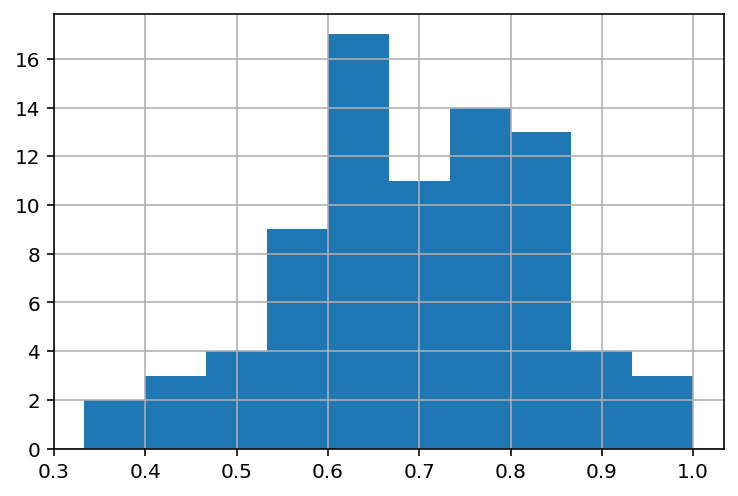

In [10]:
df['tapn'] = df['ttt'].apply(lambda x: get_apn(x, ytvs, fold='ttt'))
df['vapn'] = df['vtt'].apply(lambda x: get_apn(x, ytvs, fold='vtt'))
df['sapn'] = df['stt'].apply(lambda x: get_apn(x, ytvs, fold='stt'))
df['tapn'].apply(lambda r: get_apn_acc(*r)).hist()
df['tapn'].apply(lambda r: get_apn_acc(*r)).mean()

(0.8487500000000001, 0.8500000000000001)

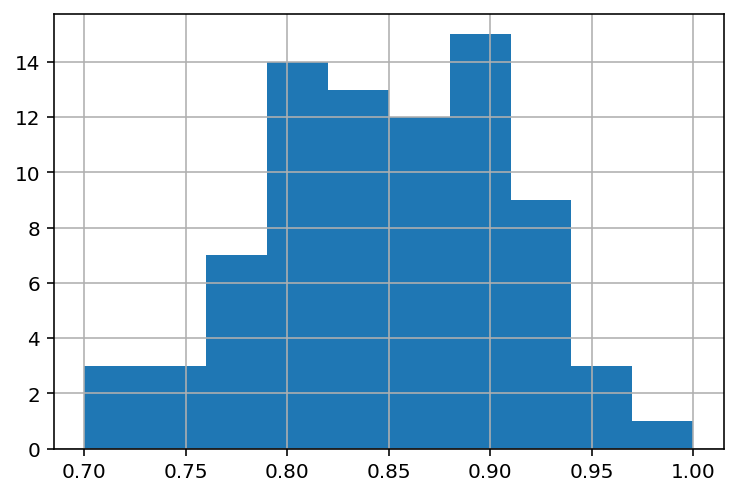

In [37]:
df['tapn'].apply(lambda r: get_filtered_apn(*r)).hist()
df['tapn'].apply(lambda r: get_filtered_apn(*r)).mean(), df['tapn'].apply(lambda r: get_filtered_apn(*r)).median()

In [8]:
from itertools import chain
ttt = np.vstack(list(chain(df['ttt'])))
vtt = np.vstack(list(chain(df['vtt'])))
stt = np.vstack(list(chain(df['stt'])))

In [9]:
filter_msk = np.where(~(
    (y_train[ttt[:,0]] == y_train[ttt[:,2]]) \
        & (y_train[ttt[:,0]] != y_train[ttt[:,1]])))[0]

In [10]:
filtered = ttt[filter_msk]
len(filtered)

2037

In [11]:
np.vstack((list(chain(df['tapn'].apply(
    lambda r: get_filtered_apn(*r)))))).sum()

2037

In [36]:
vtt_filter_msk = np.vstack((list(chain(df['vapn'].apply(
    lambda r: get_filtered_apn(*r)))))).ravel()
stt_filter_msk = np.vstack((list(chain(df['sapn'].apply(
    lambda r: get_filtered_apn(*r)))))).ravel()

In [48]:
vtt_filtered, stt_filtered = vtt[vtt_filter_msk], stt[stt_filter_msk]
vtt_filtered.shape, stt_filtered.shape

((659, 3), (662, 3))

In [46]:
vtt[np.where(~(
    (y_valid[vtt[:,0]] == y_train[vtt[:,2]]) \
        & (y_valid[vtt[:,0]] != y_train[vtt[:,1]])))[0]].shape, stt[np.where(~(
    (y_test[stt[:,0]] == y_train[stt[:,2]]) \
        & (y_test[stt[:,0]] != y_train[stt[:,1]])))[0]].shape

((659, 3), (662, 3))

In [49]:
# pickle.dump(filtered.tolist(),
#     open('../datasets/bm_prolific_triplets/train_triplets_filtered.pkl', 'wb'))
# pickle.dump(vtt_filtered.tolist(),
#     open('../datasets/bm_prolific_triplets/valid_triplets_filtered.pkl', 'wb'))
# pickle.dump(stt_filtered.tolist(),
#     open('../datasets/bm_prolific_triplets/test_triplets_filtered.pkl', 'wb'))

In [23]:
ttt_filter_msk = np.vstack((list(chain(df['tapn'].apply(
    lambda r: get_clf_apn(*r)[1]))))).ravel()
vtt_filter_msk = np.vstack((list(chain(df['vapn'].apply(
    lambda r: get_clf_apn(*r)[1]))))).ravel()
stt_filter_msk = np.vstack((list(chain(df['sapn'].apply(
    lambda r: get_clf_apn(*r)[1]))))).ravel()

In [24]:
ttt_filtered, vtt_filtered, stt_filtered = ttt[ttt_filter_msk], vtt[vtt_filter_msk], stt[stt_filter_msk]
ttt_filtered.shape, vtt_filtered.shape, stt_filtered.shape

((1208, 3), (416, 3), (416, 3))

In [38]:
ttt_filter_msk = np.vstack((list(chain(df['tapn'].apply(
    lambda r: get_clf_apn(*r)[0]))))).ravel()
vtt_filter_msk = np.vstack((list(chain(df['vapn'].apply(
    lambda r: get_clf_apn(*r)[0]))))).ravel()
stt_filter_msk = np.vstack((list(chain(df['sapn'].apply(
    lambda r: get_clf_apn(*r)[0]))))).ravel()

In [39]:
ttt_filtered, vtt_filtered, stt_filtered = ttt[ttt_filter_msk], vtt[vtt_filter_msk], stt[stt_filter_msk]
ttt_filtered.shape, vtt_filtered.shape, stt_filtered.shape

((845, 3), (275, 3), (278, 3))